In [14]:
import pandas as pd
from datetime import datetime
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
from urllib.request import Request, urlopen
import re
import glob
import re
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mvyas32\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mvyas32\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Assignment 12.2: Sentiment Analysis

#### Rudimentary Analysis

In [8]:
downloadPath = os.getcwd()
mcd = pd.read_csv(downloadPath + '\\LoughranMcDonald_MasterDictionary_2020.csv')
mcd[["Positive"]] = mcd[["Positive"]].apply(pd.to_numeric, errors = 'coerce')
mcd[["Negative"]] = mcd[["Negative"]].apply(pd.to_numeric, errors = 'coerce')
mcd.head()

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Complexity,Syllables,Source
0,AARDVARK,1,312,1.422050e-08,1.335201e-08,3.700747e-06,96,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.367356e-10,8.882163e-12,9.362849e-09,1,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,4.102067e-10,1.200533e-10,5.359747e-08,7,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,15,6.836779e-10,4.080549e-10,1.406914e-07,14,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8009,3.650384e-07,3.798698e-07,3.523914e-05,1058,0,0,0,0,0,0,0,0,3,12of12inf


In [11]:
SEC_FILLINGS = pd.read_csv(downloadPath+'\\sec_fillings.csv')
SEC_DATA = SEC_FILLINGS.iloc[:, 1:]

ALL_DATA = pd.read_csv(downloadPath+"\\master_dataset.csv")
ALL_DATA = ALL_DATA['CIK']
ALL_DATA = ALL_DATA.drop_duplicates()

merged = pd.merge(ALL_DATA, SEC_DATA, how = 'inner', on = 'CIK')
merged.head()

,CIK,CompanyName,FormTypes,DATE,link
0,353184.0,AIR T INC,8-K,2019-12-19,edgar/data/353184/0000353184-19-000056.txt
1,353184.0,AIR T INC,8-K,2019-11-14,edgar/data/353184/0000353184-19-000050.txt
2,5981.0,AMERICAN VANGUARD CORP,8-K,2019-11-06,edgar/data/5981/0001193125-19-285624.txt
3,1037868.0,AMETEK INC/,8-K,2019-10-31,edgar/data/1037868/0001193125-19-280482.txt
4,318154.0,AMGEN INC,8-K,2019-10-29,edgar/data/318154/0000318154-19-000044.txt


In [12]:
myfiles = list(merged.iloc[:, 4])

#### Getting 8-K text

In [17]:
headers = {"User-Agent": "Safari/15.1"}
for file in myfiles:
    time.sleep(0.15)
    url = 'https://www.sec.gov/Archives/' + file
    a_list = list(file.split('/'))

    req = Request(url, headers=headers) 
    fp = urlopen(req)
    with open(downloadPath + '\\8_K\\' + a_list[2] + '_' + a_list[3], "wb") as fo:
        fo.write(fp.read()) 

#### Classyfying the tone

In [22]:
word_checker = r"(?<!\S)[A-Za-z]+(?!\S)|(?<!\S)[A-Za-z]+"
def scoring(pos, neg, listfiles):
    tonelist = []
    for file in listfiles:
        with open(file) as myfile:
            txt = myfile.read()
            txt = txt.upper()
            txt = re.findall(word_checker, txt)
            pos_score = 0
            neg_score = 0
            for word in pos:
                pos_score += txt.count(word)
            for word in neg:
                neg_score += txt.count(word)
            tone = (pos_score - neg_score)/len(txt)
            tonelist.append((file, tone))
    tone_data = pd.DataFrame(tonelist)
    tone_data = tone_data.set_axis(['File', 'Tone_score'], axis = 1,inplace = False)
    return tone_data


negatives = set(mcdonald[mcdonald['Negative'] != 0]['Word'])
positives = set(mcdonald[mcdonald['Positive'] != 0]['Word'])
file_8k = glob.glob(downloadPath+"\\8_K\\*.txt")
mcdonaldfile = scoring(positives, negatives, file_8k)
mcdonaldfile.to_csv(downloadPath+"/mcdonaldfile.csv")

Clean Data

In [26]:
mcdonaldfile.head()

,File,Tone_score
0,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,-0.003666
1,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,-0.001104
2,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,0.001567
3,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,-0.000976
4,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10006...,-0.010454


In [24]:
merged_new = merged.copy()
merged_new['link'] = merged_new['link'].str[-24:]
merged_new = merged_new.rename(columns={"link": 'File'})

merged_new.head()

,CIK,CompanyName,FormTypes,DATE,File
0,353184.0,AIR T INC,8-K,2019-12-19,0000353184-19-000056.txt
1,353184.0,AIR T INC,8-K,2019-11-14,0000353184-19-000050.txt
2,5981.0,AMERICAN VANGUARD CORP,8-K,2019-11-06,0001193125-19-285624.txt
3,1037868.0,AMETEK INC/,8-K,2019-10-31,0001193125-19-280482.txt
4,318154.0,AMGEN INC,8-K,2019-10-29,0000318154-19-000044.txt


In [32]:
mcdonaldfile['File'] = mcdonaldfile['File'].str[-24:]
total_mcdonald = pd.merge(mcdonaldfile, NEW_LINK, how = 'inner', on = 'File')
CAR = pd.read_csv(downloadPath+"\\CAR.csv", header = 0)
NEW_CAR = CAR.iloc[:, 1:]
finalword = pd.merge(NEW_CAR, total_mcdonald, how = 'inner', on = 'CIK')
finalword.head()

,CIK,ATO,CAR0,CAR1,CAR2,CAR3,CAR5,File,Tone_score,CompanyName,FormTypes,DATE
0,1616262.0,-0.010565,-0.005143,0.021242,0.012578,0.013441,-0.047490,0001437749-19-022846.txt,-0.000497,"Rocky Mountain Chocolate Factory, Inc.",8-K,2019-11-14
1,1616262.0,-0.010565,-0.005143,0.021242,0.012578,0.013441,-0.047490,0001437749-19-022846.txt,-0.000497,"Rocky Mountain Chocolate Factory, Inc.",8-K,2019-11-14
2,1616262.0,-0.010565,-0.005143,0.021242,0.012578,0.013441,-0.047490,0001437749-19-023922.txt,-0.008129,"Rocky Mountain Chocolate Factory, Inc.",8-K,2019-12-05
3,1616262.0,-0.010565,-0.005143,0.021242,0.012578,0.013441,-0.047490,0001437749-19-023922.txt,-0.008129,"Rocky Mountain Chocolate Factory, Inc.",8-K,2019-12-05
4,1616262.0,-0.929316,-0.001938,-0.008142,-0.009698,-0.001882,-0.001123,0001437749-19-022846.txt,-0.000497,"Rocky Mountain Chocolate Factory, Inc.",8-K,2019-11-14


Quintile 0 Descriptive Stats: 
               ATO         CAR0         CAR1         CAR2         CAR3  \
count  1204.000000  1204.000000  1204.000000  1204.000000  1204.000000   
mean      0.495797     0.006151     0.007285     0.006731     0.001568   
std       1.221048     0.114702     0.285581     0.374628     0.406229   
min      -3.282840    -0.587161    -1.761484    -1.894813    -2.028142   
25%      -0.365982    -0.018045    -0.050132    -0.080947    -0.098634   
50%       0.383652     0.001464    -0.000308    -0.004785    -0.002994   
75%       1.217280     0.021105     0.045731     0.064761     0.083153   
max       4.543420     1.904326     5.712979     7.604982     7.580336   

              CAR5  
count  1204.000000  
mean     -0.001689  
std       0.454852  
min      -2.253025  
25%      -0.140475  
50%      -0.008319  
75%       0.110181  
max       7.434244  


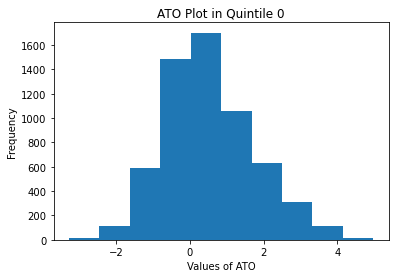

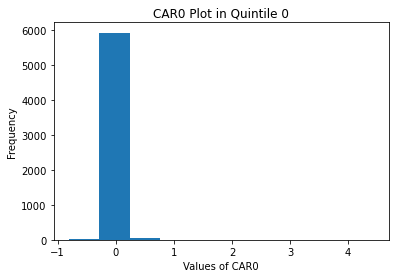

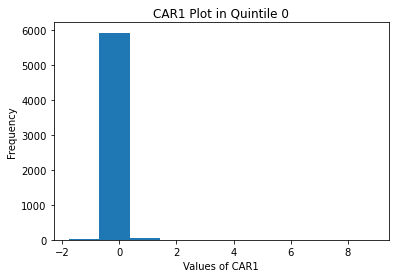

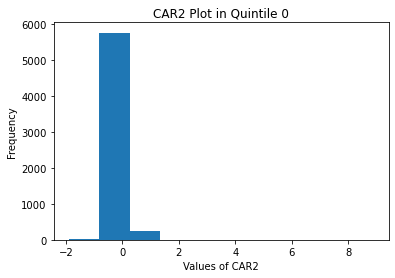

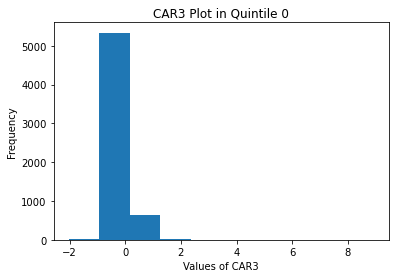

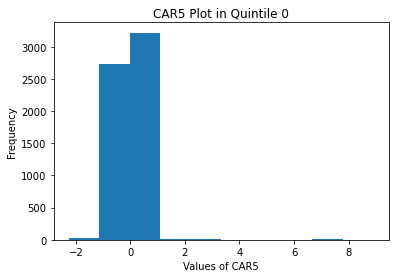

Quintile 1 Descriptive Stats: 
               ATO         CAR0         CAR1         CAR2         CAR3  \
count  1204.000000  1204.000000  1204.000000  1204.000000  1204.000000   
mean      0.518428     0.009248     0.020973     0.024206     0.018947   
std       1.221581     0.183823     0.407278     0.491815     0.513223   
min      -2.809325    -0.662827    -0.654986    -0.973862    -1.219241   
25%      -0.348775    -0.022536    -0.046758    -0.066870    -0.075487   
50%       0.350144    -0.002570    -0.004387    -0.002856    -0.007305   
75%       1.260398     0.020036     0.043635     0.057277     0.074151   
max       4.970387     4.432156     8.883267     8.889782     8.917258   

              CAR5  
count  1204.000000  
mean      0.006480  
std       0.545497  
min      -1.856900  
25%      -0.120210  
50%      -0.012175  
75%       0.100922  
max       8.905870  


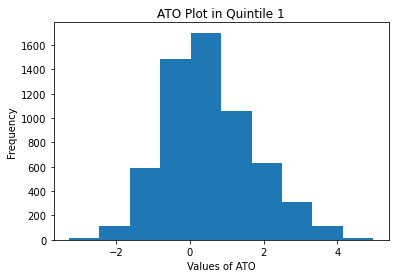

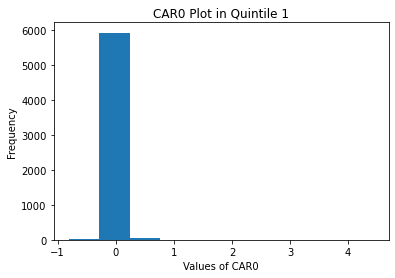

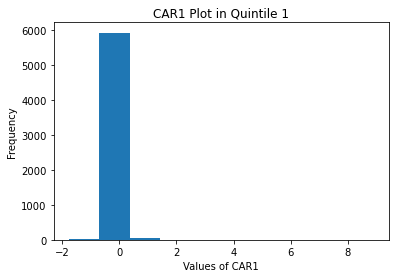

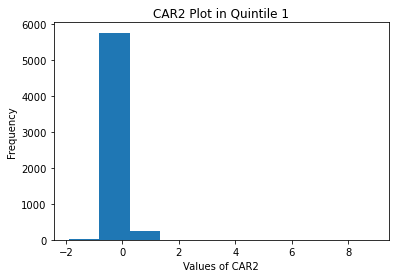

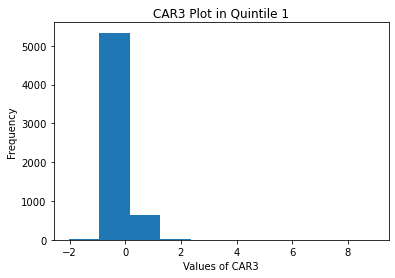

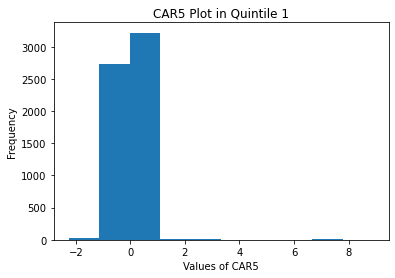

Quintile 2 Descriptive Stats: 
               ATO         CAR0         CAR1         CAR2         CAR3  \
count  1323.000000  1323.000000  1323.000000  1323.000000  1323.000000   
mean      0.600864     0.004979     0.006532     0.005711     0.001309   
std       1.208438     0.186787     0.375507     0.388515     0.405923   
min      -2.261819    -0.805788    -1.761484    -1.894813    -2.028142   
25%      -0.254667    -0.018367    -0.043006    -0.058117    -0.076858   
50%       0.463168    -0.000992    -0.001187    -0.000441     0.002271   
75%       1.356637     0.015637     0.036489     0.057361     0.068596   
max       4.856377     4.432156     8.883267     8.889782     8.917258   

              CAR5  
count  1323.000000  
mean     -0.005454  
std       0.448223  
min      -2.253025  
25%      -0.119773  
50%      -0.004125  
75%       0.093783  
max       8.905870  


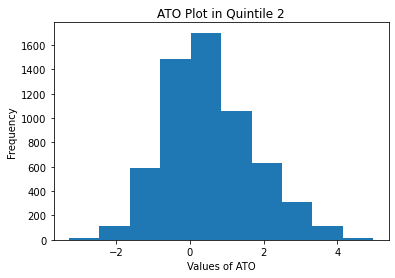

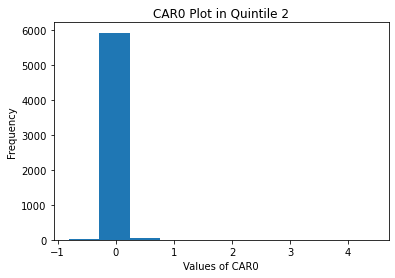

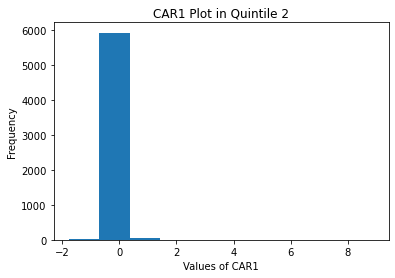

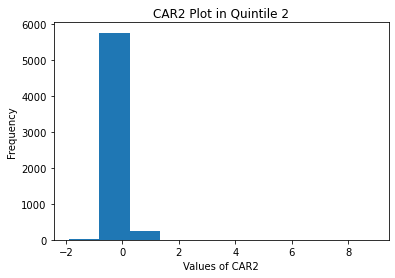

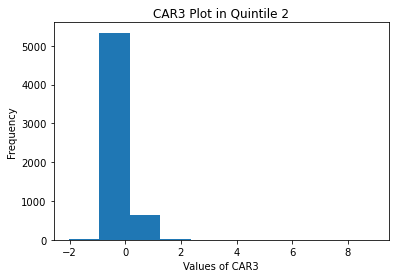

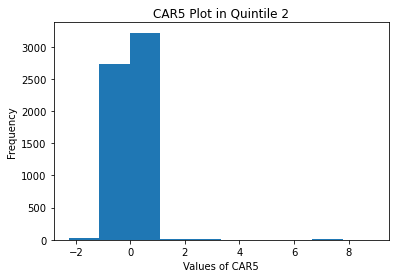

Quintile 3 Descriptive Stats: 
               ATO         CAR0         CAR1         CAR2         CAR3  \
count  1083.000000  1083.000000  1083.000000  1083.000000  1083.000000   
mean      0.545719     0.003777     0.004024     0.003722     0.002819   
std       1.208867     0.080489     0.121763     0.150583     0.192220   
min      -2.698606    -0.375185    -0.689771    -0.881761    -1.079199   
25%      -0.342571    -0.014243    -0.032714    -0.053930    -0.065282   
50%       0.385945     0.000134     0.000401    -0.000409    -0.003520   
75%       1.347218     0.015066     0.035002     0.054175     0.065765   
max       4.548081     1.939147     1.946047     1.880309     1.902849   

              CAR5  
count  1083.000000  
mean     -0.003182  
std       0.241870  
min      -1.422484  
25%      -0.092462  
50%      -0.005708  
75%       0.091877  
max       2.265522  


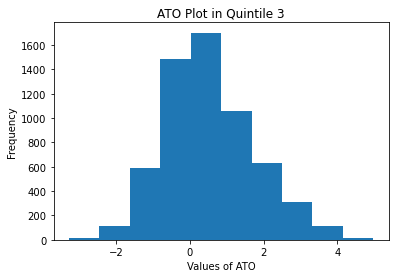

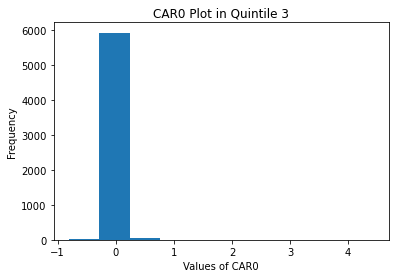

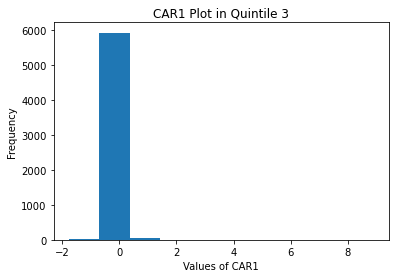

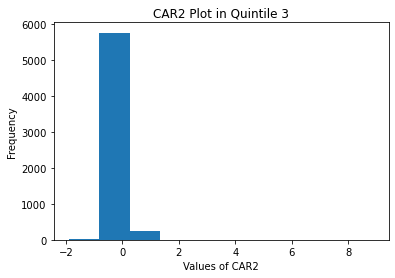

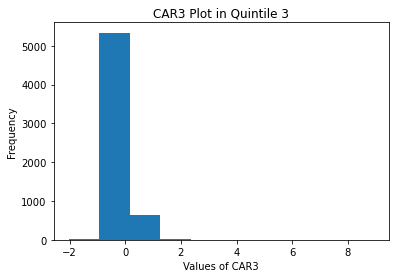

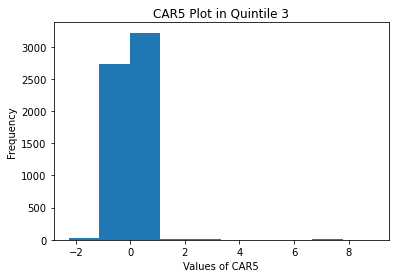

Quintile 4 Descriptive Stats: 
               ATO         CAR0         CAR1         CAR2         CAR3  \
count  1203.000000  1203.000000  1203.000000  1203.000000  1203.000000   
mean      0.453738     0.002464     0.004299     0.002728     0.001322   
std       1.170195     0.050678     0.111961     0.142307     0.188520   
min      -3.179012    -0.315132    -0.737076    -0.840323    -1.002729   
25%      -0.342696    -0.016536    -0.037275    -0.059340    -0.080972   
50%       0.282101     0.000486     0.001541    -0.000987    -0.003295   
75%       1.123162     0.017071     0.040143     0.056163     0.067427   
max       4.665410     0.552059     1.656177     1.720039     2.488107   

              CAR5  
count  1203.000000  
mean     -0.003047  
std       0.247307  
min      -1.058794  
25%      -0.117884  
50%      -0.002348  
75%       0.096708  
max       2.813988  


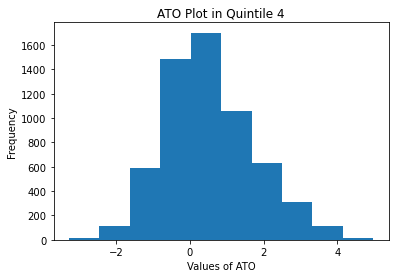

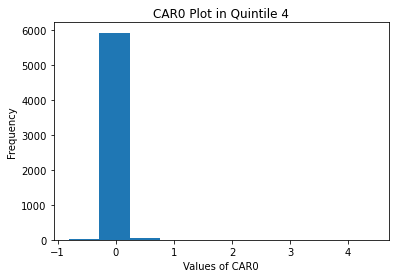

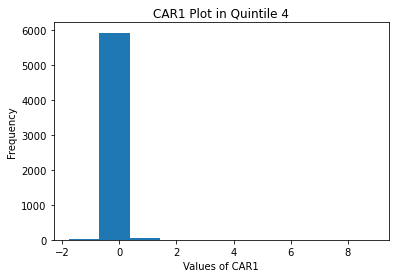

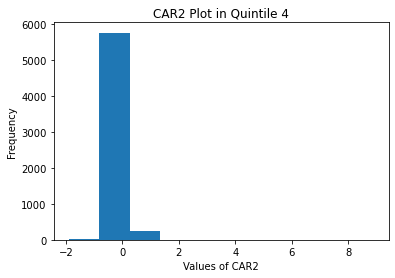

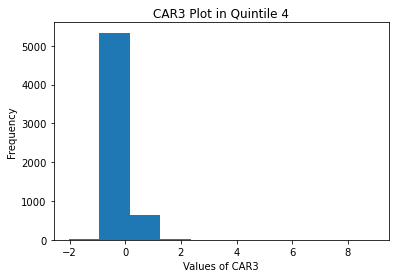

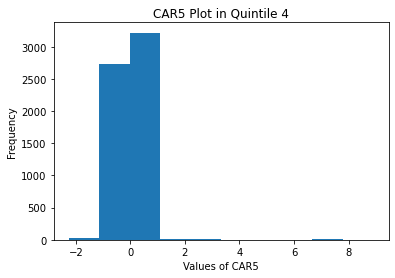

In [34]:
finalword['QUINTILE'] = pd.qcut(finalword['Tone_score'], q=5, labels = False)
finalword.to_csv(downloadPath+"/finalword.csv")

vlist = ('ATO', 'CAR0', 'CAR1', 'CAR2', 'CAR3', 'CAR5')


for i in range (0, 5):
    val = finalword.loc[finalword['QUINTILE'] == i]
    print('Quintile', i, 'Descriptive Stats: ')
    describeval = val[['ATO'] + ['CAR0'] + ['CAR1'] + ['CAR2'] + ['CAR3'] + ['CAR5']]
    print(describeval.describe())
    for j in vlist:
        plot = finalword[j].plot.hist()
        plt.xlabel('Values of ' + str(j))
        plt.title(str(j) + ' Plot in Quintile ' + str(i))
        plt.show()

### Assignment 12.2 : Less Rudimentary Analysis

Reading mcdonald dictionary

In [36]:
mcdonald = pd.read_csv(downloadPath+"/mcdonaldfile.csv")
mcdonald['FULL'] = mcdonald['File']
mcdonald['File'] = mcdonald['File'].str[-24:]
merged_data = pd.merge(mcdonald, finalword, how = 'inner', on = 'File')
merged_data.head()

,Unnamed: 0,File,Tone_score_x,FULL,CIK,ATO,CAR0,CAR1,CAR2,CAR3,CAR5,Tone_score_y,CompanyName,FormTypes,DATE,QUINTILE
0,0,0001193125-19-270398.txt,-0.003666,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,1000228.0,0.337605,-0.001092,-0.029707,0.000391,0.014841,-0.029975,-0.003666,HENRY SCHEIN INC,8-K,2019-10-21,1
1,0,0001193125-19-270398.txt,-0.003666,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,1000228.0,0.337605,-0.001092,-0.029707,0.000391,0.014841,-0.029975,-0.003666,HENRY SCHEIN INC,8-K,2019-10-21,1
2,0,0001193125-19-270398.txt,-0.003666,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,1000228.0,4.024751,-0.037305,-0.066928,-0.058776,-0.068774,-0.085849,-0.003666,HENRY SCHEIN INC,8-K,2019-10-21,1
3,0,0001193125-19-270398.txt,-0.003666,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,1000228.0,4.024751,-0.037305,-0.066928,-0.058776,-0.068774,-0.085849,-0.003666,HENRY SCHEIN INC,8-K,2019-10-21,1
4,1,0001193125-19-319710.txt,-0.001104,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,1000228.0,0.337605,-0.001092,-0.029707,0.000391,0.014841,-0.029975,-0.001104,HENRY SCHEIN INC,8-K,2019-12-20,1


#### Tone Classification

In [38]:
def less_rudimentary(files):
    tonelist = []
    for file in files:
        with open(file) as myfile:
            txt = myfile.read()
            txt = txt.upper()
            token = sent_tokenize(txt)
            analyze = SentimentIntensityAnalyzer()
            x = 0
            y = 0
            for sentence in token:
                x += 1
                polarity = analyze.polarity_scores(sentence)['compound']
                y += polarity
            score = y/x
            tonelist.append((file, score))
    tonesentence = pd.DataFrame(tonelist)
    return tonesentence

merged_data_dropped = merged_data['FULL'].drop_duplicates()
merged_data_dropped_list = merged_data_dropped.to_list()
sentences = less_rudimentary(merged_data_dropped_list)

In [40]:
sentences.to_csv(downloadPath+"/less_rudi.csv")

In [43]:
rudy = pd.read_csv(downloadPath+"/less_rudi.csv")
rudy = rudy.iloc[:, 1:]
rudy = rudy.rename(columns={rudy.columns[0]: 'FULL'})
rudy = rudy.rename(columns={rudy.columns[1]: 'sentence_tone'})
merged_final = pd.merge(rudy, merged_data, how = 'inner', on = 'FULL')
merged_final.head()


,FULL,sentence_tone,Unnamed: 0,File,Tone_score_x,CIK,ATO,CAR0,CAR1,CAR2,CAR3,CAR5,Tone_score_y,CompanyName,FormTypes,DATE,QUINTILE
0,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,0.038465,0,0001193125-19-270398.txt,-0.003666,1000228.0,0.337605,-0.001092,-0.029707,0.000391,0.014841,-0.029975,-0.003666,HENRY SCHEIN INC,8-K,2019-10-21,1
1,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,0.038465,0,0001193125-19-270398.txt,-0.003666,1000228.0,0.337605,-0.001092,-0.029707,0.000391,0.014841,-0.029975,-0.003666,HENRY SCHEIN INC,8-K,2019-10-21,1
2,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,0.038465,0,0001193125-19-270398.txt,-0.003666,1000228.0,4.024751,-0.037305,-0.066928,-0.058776,-0.068774,-0.085849,-0.003666,HENRY SCHEIN INC,8-K,2019-10-21,1
3,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,0.038465,0,0001193125-19-270398.txt,-0.003666,1000228.0,4.024751,-0.037305,-0.066928,-0.058776,-0.068774,-0.085849,-0.003666,HENRY SCHEIN INC,8-K,2019-10-21,1
4,C:\Users\mvyas32\Downloads\HW12\HW12\8_K\10002...,0.083965,1,0001193125-19-319710.txt,-0.001104,1000228.0,0.337605,-0.001092,-0.029707,0.000391,0.014841,-0.029975,-0.001104,HENRY SCHEIN INC,8-K,2019-12-20,1


Quintile 0 Descriptive Stats: 
               ATO         CAR0         CAR1         CAR2         CAR3  \
count  1207.000000  1207.000000  1207.000000  1207.000000  1207.000000   
mean      0.581988     0.009784     0.015074     0.013907     0.008608   
std       1.195169     0.190957     0.383170     0.393320     0.410366   
min      -2.165339    -0.805788    -1.761484    -1.894813    -2.028142   
25%      -0.264409    -0.015673    -0.034818    -0.058003    -0.074849   
50%       0.435156     0.000641     0.001485    -0.003588    -0.005760   
75%       1.335095     0.018866     0.035643     0.057712     0.073392   
max       4.438219     4.432156     8.883267     8.889782     8.917258   

              CAR5  
count  1207.000000  
mean      0.005538  
std       0.446048  
min      -2.253025  
25%      -0.105479  
50%      -0.006474  
75%       0.094360  
max       8.905870  


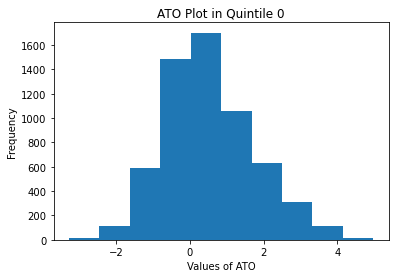

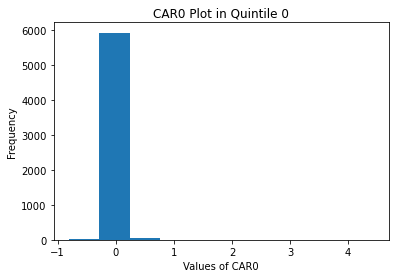

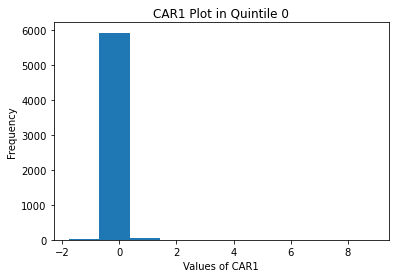

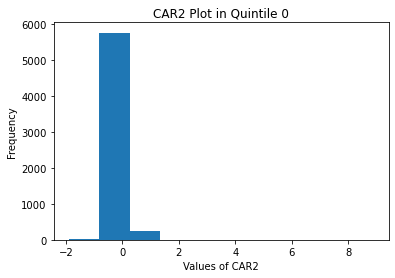

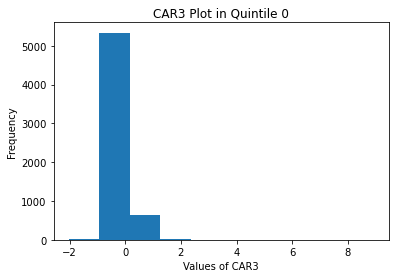

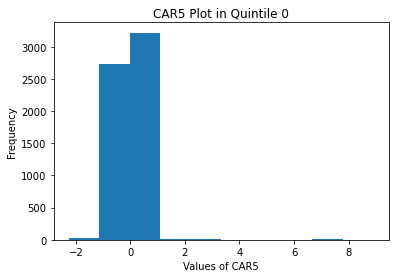

Quintile 1 Descriptive Stats: 
               ATO         CAR0         CAR1         CAR2         CAR3  \
count  1201.000000  1201.000000  1201.000000  1201.000000  1201.000000   
mean      0.612901     0.000386    -0.000238    -0.002824    -0.002522   
std       1.228133     0.080349     0.127386     0.161108     0.208120   
min      -2.698606    -0.570013    -0.689771    -0.881761    -1.079199   
25%      -0.278383    -0.017661    -0.041194    -0.059485    -0.079272   
50%       0.497423    -0.000937    -0.002790    -0.001911    -0.004461   
75%       1.441362     0.016448     0.041086     0.051968     0.068529   
max       4.970387     1.939147     1.946047     1.880309     1.902849   

              CAR5  
count  1201.000000  
mean     -0.006771  
std       0.285856  
min      -1.856900  
25%      -0.112542  
50%      -0.007586  
75%       0.093835  
max       1.922280  


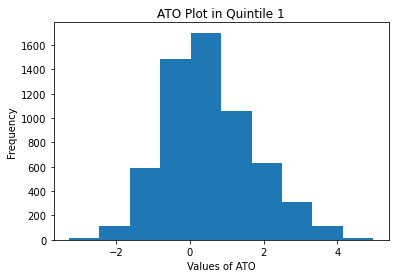

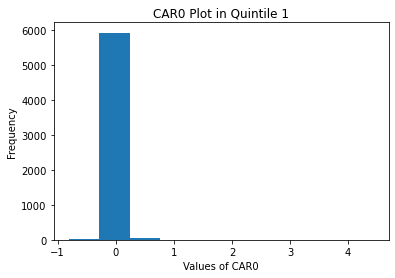

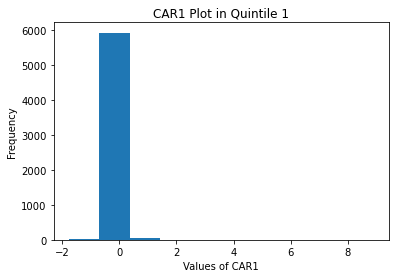

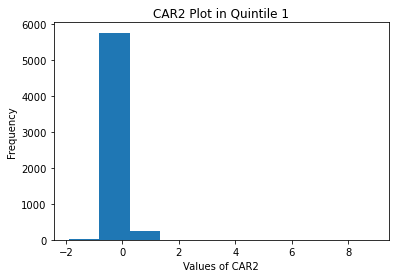

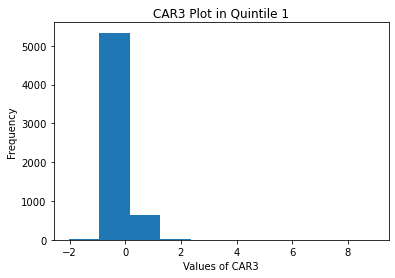

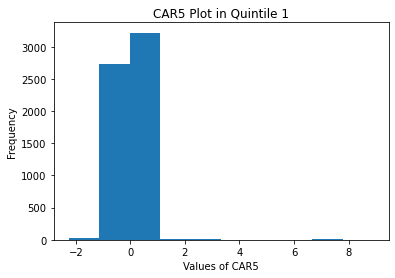

Quintile 2 Descriptive Stats: 
               ATO         CAR0         CAR1         CAR2         CAR3  \
count  1205.000000  1205.000000  1205.000000  1205.000000  1205.000000   
mean      0.593721     0.005217     0.006888     0.007272     0.008849   
std       1.239482     0.077426     0.118189     0.142697     0.174153   
min      -2.652892    -0.570013    -0.689771    -0.881761    -1.079199   
25%      -0.310280    -0.013361    -0.036899    -0.048394    -0.059814   
50%       0.417995     0.000627     0.001856     0.005601     0.004866   
75%       1.399417     0.016916     0.038883     0.056316     0.067320   
max       4.856377     1.939147     1.946047     1.880309     1.902849   

              CAR5  
count  1205.000000  
mean      0.010155  
std       0.219197  
min      -1.356799  
25%      -0.085849  
50%       0.004268  
75%       0.102817  
max       2.293023  


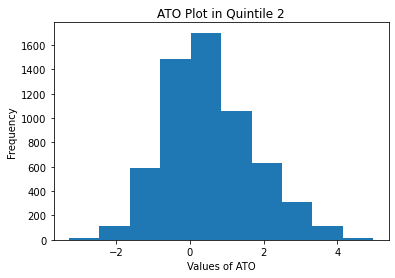

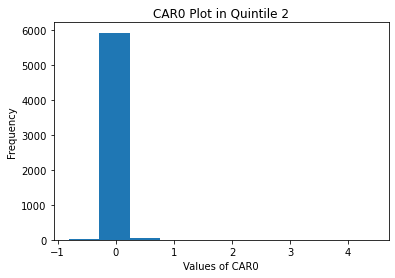

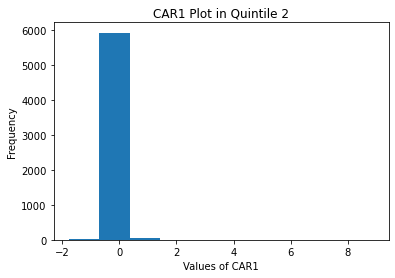

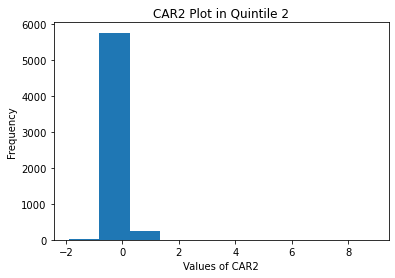

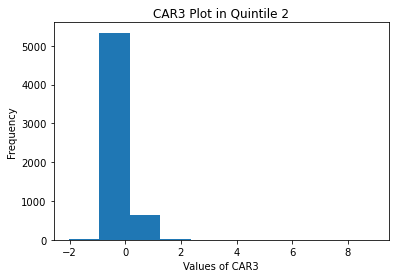

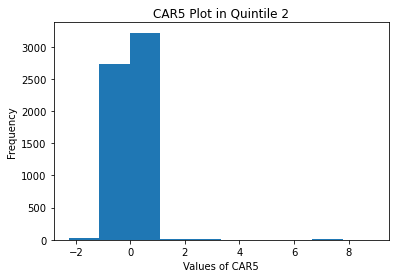

Quintile 3 Descriptive Stats: 
               ATO         CAR0         CAR1         CAR2         CAR3  \
count  1202.000000  1202.000000  1202.000000  1202.000000  1202.000000   
mean      0.452561     0.001479     0.004690     0.005972     0.000812   
std       1.199398     0.120698     0.322429     0.429607     0.463389   
min      -3.179012    -0.662827    -1.761484    -1.894813    -2.028142   
25%      -0.359349    -0.021931    -0.051185    -0.078253    -0.095389   
50%       0.288358    -0.001938    -0.002221    -0.007075    -0.009418   
75%       1.118864     0.017399     0.045415     0.064497     0.079011   
max       4.543420     1.904326     5.712979     7.604982     7.580336   

              CAR5  
count  1202.000000  
mean     -0.010660  
std       0.507726  
min      -2.253025  
25%      -0.142975  
50%      -0.017460  
75%       0.104689  
max       7.434244  


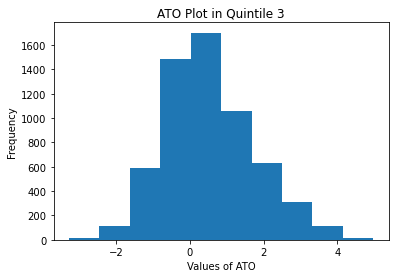

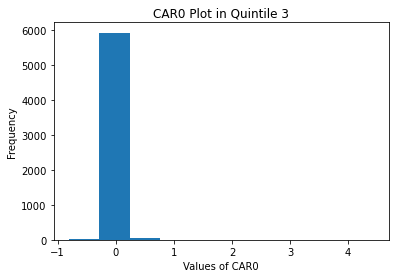

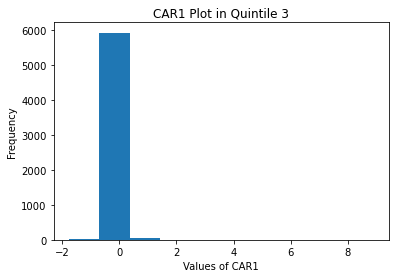

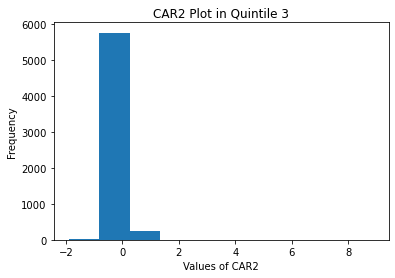

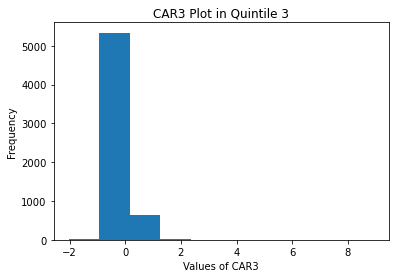

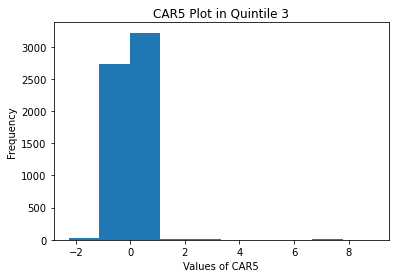

Quintile 4 Descriptive Stats: 
               ATO         CAR0         CAR1         CAR2         CAR3  \
count  1204.000000  1204.000000  1204.000000  1204.000000  1204.000000   
mean      0.379281     0.009824     0.016795     0.018753     0.009846   
std       1.153669     0.173464     0.383544     0.450757     0.470763   
min      -3.282840    -0.587161    -1.761484    -1.894813    -2.028142   
25%      -0.356578    -0.022764    -0.050854    -0.076784    -0.103216   
50%       0.260791    -0.001278    -0.004491    -0.004951    -0.007305   
75%       1.052874     0.018756     0.041083     0.057689     0.073814   
max       4.184697     4.432156     8.883267     8.889782     8.917258   

              CAR5  
count  1204.000000  
mean     -0.005719  
std       0.502366  
min      -2.253025  
25%      -0.140188  
50%      -0.008686  
75%       0.105398  
max       8.905870  


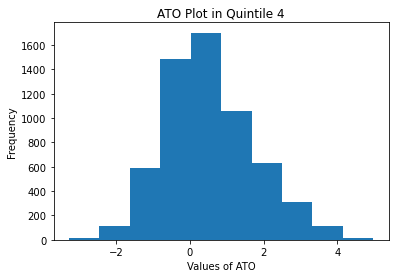

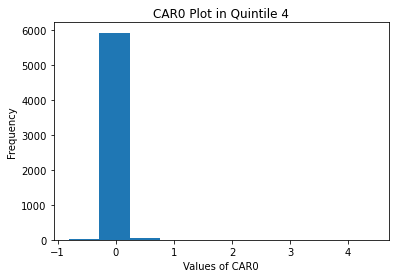

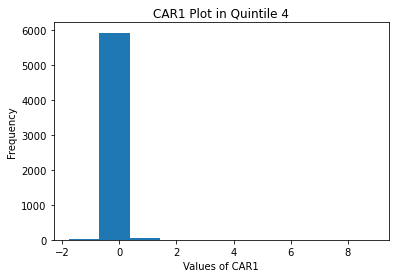

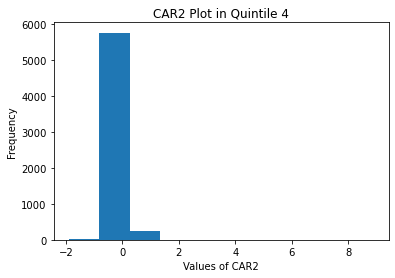

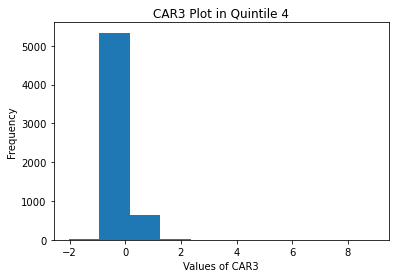

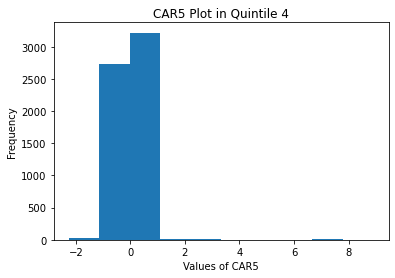

In [44]:
merged_final['QUINTILE'] = pd.qcut(merged_final['sentence_tone'], q=5, labels = False)
mylist = ('ATO', 'CAR0', 'CAR1', 'CAR2', 'CAR3', 'CAR5')


for i in range (0, 5):
    val = merged_final.loc[merged_final['QUINTILE'] == i]
    print('Quintile', i, 'Descriptive Stats: ')
    describeval = val[['ATO'] + ['CAR0'] + ['CAR1'] + ['CAR2'] + ['CAR3'] + ['CAR5']]
    print(describeval.describe())
    for j in mylist:
        plot = merged_final[j].plot.hist()
        plt.xlabel('Values of ' + str(j))
        plt.title(str(j) + ' Plot in Quintile ' + str(i))
        plt.show()